In [1]:
import pandas as pd
import pickle as pkl
from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import create_class_ADNI, main, baseline_model
import seaborn as sns
import matplotlib.pyplot as plt

# plt.style.use('ggplot')
sns.set(font="Helvetica")

**1. Create table datasets**

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for more-standard machine learning models.

In [8]:
diseases = ['AD', 'ND']

for disease in diseases:

    infile1 = f'data/ADNI/{disease}_PPI_missense.csv'
    infile2 = 'data/ADNI/ADNIMERGE_genetics_biomarkers.csv'

    table_dataset = adni_data('missense', disease, infile1, infile2)
    table_dataset.to_csv(f'data/table_datasets/{disease}_PPI_missense_with_biomarkers.csv')

In [3]:
targets = ['PET', 'PETandDX']

for target in targets:

    infile = f'data/table_datasets/AD_PPI_missense_with_biomarkers.csv'
    data = pd.read_csv(infile, index_col = 0)
    data_wclass = create_class_ADNI(data, target)

    x = data_wclass.drop(columns=['y'])
    x = x['APOE']

    y = data_wclass['y']
    x.index = x.index.str.upper()

    f = open(f'data/splits/split_{target}.pkl', 'rb')
    split_pet = pkl.load(f)
    f.close()

    auc_pet = baseline_model(split_pet, x, y)
    print(f'Baseline model {target}, AUC ROC:', auc_pet)

Class distribution:
1.0    410
0.0    316
Name: y, dtype: int64

Confusion matrix:
 [[ 6 26]
 [ 2 39]]

              precision    recall  f1-score   support

         0.0       0.75      0.19      0.30        32
         1.0       0.60      0.95      0.74        41

    accuracy                           0.62        73
   macro avg       0.68      0.57      0.52        73
weighted avg       0.67      0.62      0.54        73

Baseline model PET, AUC ROC: 0.6894054878048781
Class distribution:
1.0    182
0.0    135
Name: y, dtype: int64

Confusion matrix:
 [[ 8  6]
 [ 2 16]]

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.73      0.89      0.80        18

    accuracy                           0.75        32
   macro avg       0.76      0.73      0.73        32
weighted avg       0.76      0.75      0.74        32

Baseline model PETandDX, AUC ROC: 0.6825396825396824


**2. Run no-GNN models**

Run more-standard machine learning models 3 times (to properly compare with the 3 runs for each GNN model).

In [3]:
targets = ['PET', 'PETandDX']
diseases = ['AD', 'ND']

for target in targets:
    for disease in diseases:
        for i in range(1, 4):
            result_ad = main('ADNI', disease, 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_rep{i}')
            result_ad_noAPOE = main('ADNI_noAPOE', disease, 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_noAPOE_rep{i}')

FileNotFoundError: [Errno 2] No such file or directory: 'data/table_datasets/AD_PPI_missense_with_biomarkers.csv'

Joint results of both baseline, no-GNN, and GNN models are in [results/GNNs_comparison](results/GNNs_comparison/) for [PET](results/GNNs_comparison/2022_01_PET.csv) and [PET&DX](results/GNNs_comparison/2022_01_PETandDX.csv) targets.

Next lines plot these results obtained using ADNI dataset (Figure 2 of the paper).

In [10]:
def barplot_comparision_ml(target, bs, df, metric, title):
    
    colors = ["#F8766D", "#a3a500", "#00bf7d", "#00b0f6", "#E76BF3"]
#     colors = ["#D39200", "#00B9E3", "#F8766D", "#00BA38", "#DB72FB"]
    custom = sns.set_palette(sns.color_palette(colors))
#     custom=sns.color_palette("bright", 5)

    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x = 'Dataset',
                     y = metric,
                     hue = 'Model',
                     ci = 'sd',
                     data = df,
                     palette = custom)
    plt.axhline(y=bs, color='r', linestyle='dotted', label=f'Baseline model ({bs})')
    plt.legend(fontsize=14, loc='upper right')
    plt.ylim(0.0, 1.0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.xaxis.label.set_visible(False)
    plt.ylabel(f'{metric} obtained in test set', fontsize=16)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    plt.savefig(f'figures/figure2{title}.pdf', dpi=500)
    plt.savefig(f'figures/figure2{title}.png', dpi=500)

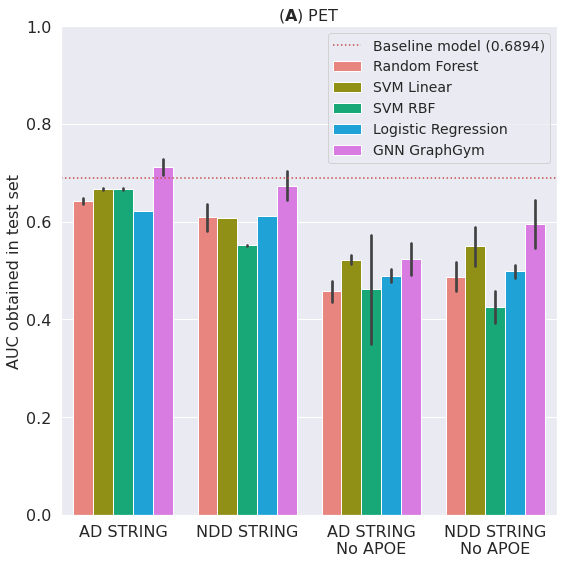

In [18]:
pet_results = pd.read_csv('results/GNNs_comparison/2022_01_PET.csv')
pet_baseline = pet_results.iloc[60]
pet_results.drop([60], inplace=True)

barplot_comparision_ml('PET', pet_baseline['AUC'], pet_results, 'AUC', r"($\bf{A}$) PET")

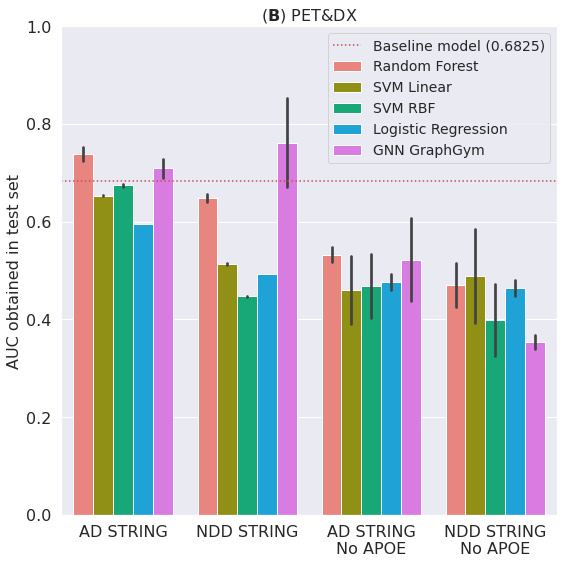

In [20]:
petdx_results = pd.read_csv('results/GNNs_comparison/2022_01_PETandDX.csv')
petdx_baseline = petdx_results.iloc[60]
petdx_results.drop([60], inplace=True)

barplot_comparision_ml('PET&DX', petdx_baseline['AUC'], petdx_results, 'AUC', r"($\bf{B}$) PET&DX")

In [27]:
def statistics(df, baseline):
    gnn_res = []
    for d in df['Dataset'].unique():
        tmp = df.loc[df['Dataset'] == d]
        gnn = tmp.loc[tmp['Model'] == 'GNN GraphGym']['AUC'].values
        gnn_res.append(gnn)
        t1, p1 = stats.ttest_1samp(gnn, baseline, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
        print(d)
        print('**Baseline', p1)
        for m in ['Random Forest', 'SVM Linear', 'SVM RBF', 'Logistic Regression', 'GNN GraphGym']:
            tmp_model = tmp.loc[tmp['Model'] == m]
            values = tmp_model['AUC'].values
            t2, p2 = stats.ttest_1samp(values, baseline, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
            t3, p3 = stats.ttest_ind(gnn, values, alternative='greater') # mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
            print(m, p2, p3)
        print()

    t4, p4 = stats.ttest_ind(gnn_res[0], gnn_res[1])
    print(p4)

In [28]:
from scipy import stats

gnn_pet =statistics(pet_results, 0.6894)
print()
gnn_petdx = statistics(petdx_results, 0.6825)
print()



AD STRING
**Baseline 0.09493982763230241
Random Forest 0.9961570711162681 0.0024005497433117508
SVM Linear 0.9982605151146682 0.00906852049959481
SVM RBF 0.9990396753666421 0.009063765745967655
Logistic Regression 1.0 0.0007468359768181541
GNN GraphGym 0.09493982763230241 0.5

NDD STRING
**Baseline 0.7364849905279487
Random Forest 0.9718668955396946 0.04318391217233518
SVM Linear 0.9999988164149289 0.01568491581602996
SVM RBF 0.9999932289410111 0.0020088518186297455
Logistic Regression 1.0 0.019307636816056867
GNN GraphGym 0.7364849905279487 0.5

AD STRING
No APOE
**Baseline 0.9905355830426021
Random Forest 0.9978383168841474 0.03825834099161424
SVM Linear 0.9992074742605306 0.47225443765653524
SVM RBF 0.9488358271454188 0.2461556676554545
Logistic Regression 0.9988970369362813 0.12221528380613232
GNN GraphGym 0.9905355830426021 0.5

NDD STRING
No APOE
**Baseline 0.9424784263729556
Random Forest 0.9947168049445985 0.027596404781307888
SVM Linear 0.9807423485417415 0.18100006233562724
S

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


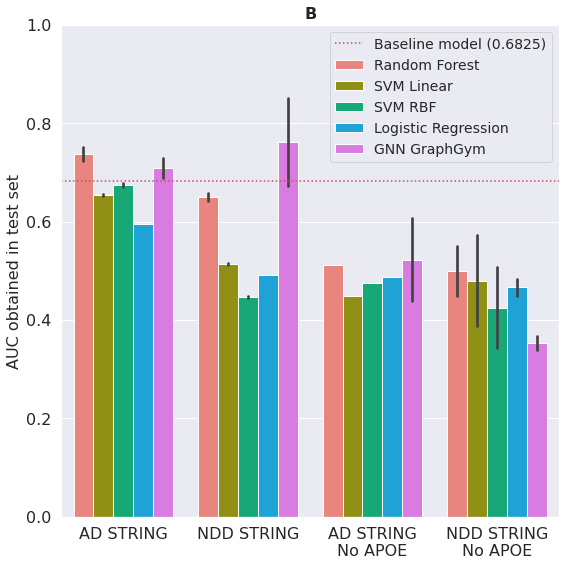